In [1]:
import pandas as pd
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as opt
from scipy import interpolate
from scipy import signal

import pickle
%matplotlib inline

In [2]:
# Стандартное импортирование plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as offline

import warnings
warnings.filterwarnings('ignore')

In [18]:
df=pd.read_table('hist.inc', skiprows=15, 
                 usecols=['--WELL',"'DD.MM.YYYY'", 'QOIL', 'QWAT', 'QWIN', 'WEFA', 'BHPH', 'THPH'])

In [19]:
skin_model=pickle.load(open('skin_model.sav', 'rb'))

In [20]:
df.columns=['WELL', 'date', 'QOIL', 'QWAT', 'QWIN', 'WEFA', 'BHPH', 'THPH']
df['WELL'] = df['WELL'].astype('str')

In [21]:
df['date']=pd.to_datetime(df['date'], format = '%d.%m.%Y')

In [22]:
df.drop(df[df['date']>pd.to_datetime('today')].index, inplace=True)

In [23]:
df.index=df['date']

In [24]:
T = df['date'].max()-pd.DateOffset(months=1)
def full_date(frame, max_date=T):
    nulls = pd.DataFrame(np.nan, index=pd.date_range(frame['date'].max(), max_date, freq ='MS'), columns=frame.columns)
    frame = pd.concat([frame, nulls])
    return frame

In [25]:
df=pd.DataFrame(df.groupby(by='WELL').apply(full_date))

In [26]:
df.drop(columns=['WELL', 'date'], inplace=True)#.reset_index()

In [27]:
df.reset_index(inplace=True) #.loc['3076']

In [28]:
df.columns=['WELL', 'date', 'QOIL', 'QWAT', 'QWIN', 'WEFA', 'BHPH', 'THPH']

In [29]:
df.fillna(0,inplace=True)

In [30]:
df['THPH']=df['THPH'].replace([-999,0], np.nan)
df['BHPH']=df['BHPH'].replace([-999,0], np.nan)

In [31]:
df['QLIQ'] = df['QOIL']+df['QWAT']
df['WCT']=(df['QLIQ']-df['QOIL'])/df['QLIQ']

In [32]:
df['status'] = 'prod'
df.loc[df['QWIN']>0, 'status'] = 'inj'
df.loc[((df['QWIN']==0)&(df['QLIQ']==0)), 'status'] = 'not_work'

In [3]:
def day_in_month(i):
      return calendar.monthrange(i.year,i.month)[1]

In [4]:
def wellwiz(well, frame):
    sub=frame[frame['WELL']==str(well)]
    fig=plt.figure(figsize=(20,8))
    ax1=fig.add_subplot(121)
    ax1.step(sub.index, sub['QOIL'], color='r')
    ax1.plot(sub.index, sub['QLIQ'], color='g', alpha=0.5)
    ax1.plot(sub.index, sub['SQLIQ'], 'g--')
    ax2=plt.twinx()
    ax2.plot(sub.index, sub['THPH'],marker='o', markersize=2, linestyle='None')
    ax2.plot(sub.index, sub['STHPH'], 'k--')
    ax2.plot(sub.index, sub['BHPH'],marker='o', markersize=2, linestyle='None')
    ax2.plot(sub.index, sub['SBHPH'],'r--')
    ax3=fig.add_subplot(122)
    ax3.plot(sub.index, sub['WCT'], color='b', alpha=0.5)
    ax3.plot(sub.index, sub['SWCT'], color='k')
    return plt.show()

In [5]:
def montly_dob (frame, summ_list=['QOIL', 'QWAT', 'QLIQ', 'QWIN', 'SQOIL', 'SQLIQ']):
    for i in summ_list:
        name='MON'+i
        name2='SUMM'+i
        frame[name]=frame['date'].apply(day_in_month)*frame[i]*frame['WEFA']
        frame[name2]=frame[name].cumsum()/1000
    return frame

In [6]:
def product_calc (frame, smooth=False):
    if smooth == True:
        frame['SPROD']=frame['SQLIQ']/(frame['STHPH']-frame['SBHPH'])
        frame['PROD']=frame['QLIQ']/(frame['THPH']-frame['BHPH'])
        frame.loc[frame['QLIQ'].isnull(), 'SPROD'] = np.NaN
    else:
        frame['PROD']=frame['QLIQ']/(frame['THPH']-frame['BHPH'])
    return frame
def mproduct_calc (frame):
    frame['PRODM']=frame['SQLIQ']/(frame['THPM']-frame['BHPM'])
    return frame

In [7]:
def tsplot(frame, param='', figsize=(12, 7), style='bmh'):
    smothparam = 'S'+param 
    difparam = param + '_delta'

    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        main_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        dif_ax = plt.subplot2grid(layout, (1, 0))
        hist_ax = plt.subplot2grid(layout, (1, 1))
        

        frame[param].plot(ax=main_ax)
        frame[smothparam].plot(ax=main_ax)
        main_ax.set_title('значение {}'.format(param))
        dif_ax.fill_between(frame.index,  frame[difparam], 1,  where=frame[difparam]>1, facecolor='red')
        dif_ax.fill_between(frame.index, frame[difparam], 1, where=frame[difparam]<1, facecolor='green')
        frame[param].plot(kind='hist', bins = 50, ax=hist_ax, alpha=0.5)
        frame[smothparam].plot(kind='hist', bins = 50, ax=hist_ax, alpha=0.5)
        hist_ax.legend()
        plt.tight_layout()
    return

### Предобработка значений по давлению

In [38]:
df.loc[((df['BHPH']>df['THPH'])&(df['status']=='prod')), 'THPH'] = np.NaN

In [39]:
#df.loc[((df['BHPH']>df['THPH'])&(df['status']=='prod')), 'THPH'] = df.loc[((df['BHPH']>df['THPH'])&(df['status']=='prod')), 'BHPH']

In [40]:
#df.loc[((df['BHPH']>=df['THPH'])&(df['status']=='prod')), 'BHPH'] = np.NaN
#df.loc[((df['BHPM']>=df['THPM'])&(df['status']=='prod')), 'BHPM'] = np.NaN
df.loc[(df['BHPH']<10), 'BHPH'] = np.NaN
df.loc[(df['THPH']<10), 'THPH'] = np.NaN
df.loc[(df['status']=='not_work'), 'BHPH'] = np.NaN
df.loc[(df['status']=='not_work'), 'BHPM'] = np.NaN
df.loc[(df['status']=='not_work'), 'THPM'] = np.NaN

# Функции для сглаживания исторических данных

In [8]:
def interpolate_press(frame, rollwin = 30):
    frame.index=frame['date']
    frame['SBHPH']=frame['BHPH'].interpolate(method='time').rolling(rollwin).mean().shift(-8)
    frame['STHPH']=frame['THPH'].interpolate(method='time').rolling(rollwin).mean().shift(-8)
    frame.loc[(frame['status']=='not_work'), 'SBHPH'] = np.NaN
    frame.reset_index(drop=True, inplace=True)
    return frame

b, a = signal.butter(5, 0.1)
def interpolate_press_by_sipy(frame, a=a, b=b):
    if frame.shape[0]>12:
        frame.index=frame['date']
        frame['SBHPH']= signal.filtfilt(b, a, frame['BHPH'].interpolate(method='time').fillna(method='bfill')) 
        frame['STHPH']= signal.filtfilt(b, a, frame['THPH'].interpolate(method='time').fillna(method='bfill')) 
        frame.loc[frame['BHPH'].interpolate(method='time').isnull(), 'SBHPH'] = np.NaN
        frame.loc[frame['THPH'].interpolate(method='time').isnull(), 'STHPH'] = np.NaN
        frame.loc[(frame['status']=='not_work'), 'SBHPH'] = np.NaN
        frame.reset_index(drop=True, inplace=True)
    else:
        frame['SBHPH']= np.NaN 
        frame['STHPH']= np.NaN
    return frame

In [9]:
def interpolate_lik(frame, rollwin = 12):
    shift=int(round(((0.2+rollwin/3)*-1),0))
    frame.index=frame['date']
    frame['SQLIQ']=frame['QLIQ'].rolling(rollwin,min_periods=2,win_type ='triang').mean().shift(shift)
    frame.loc[(frame['status']=='not_work'), 'SQLIQ'] = 0
    frame.loc[(frame['status']=='inj'), 'SQLIQ'] = 0
    frame.reset_index(drop=True, inplace=True)
    return frame

def interpolate_wct(frame, rollwin = 12):
    shift=int(round(((0.2+rollwin/3)*-1),0))
    frame.index=frame['date']
    frame['SWCT']=frame['WCT'].rolling(rollwin,min_periods=2,win_type ='triang').mean().shift(shift)
    frame.loc[(frame['status']=='not_work'), 'SWCT'] = 0
    frame.loc[(frame['status']=='inj'), 'SWCT'] = 0
    frame.reset_index(drop=True, inplace=True)
    return frame

def interpolate_win(frame, rollwin = 12):
    shift=int(round(((0.2+rollwin/3)*-1),0))
    frame.index=frame['date']
    frame['SWIN']=frame['QWIN'].rolling(rollwin,min_periods=2,win_type ='triang').mean().shift(shift)
    frame.loc[(frame['status']=='not_work'), 'SWIN'] = 0
    frame.loc[(frame['status']=='prod'), 'SWIN'] = 0
    frame.reset_index(drop=True, inplace=True)
    return frame    

## Применение функций к основному фрейму

In [70]:
%%time
df=pd.DataFrame(df.groupby(by='WELL').apply(interpolate_press_by_sipy))
df.reset_index(drop=True, inplace=True)

ValueError: The length of the input vector x must be greater than padlen, which is 18.

In [71]:
df=pd.DataFrame(df.groupby(by='WELL').apply(interpolate_lik))
df.reset_index(drop=True, inplace=True)

In [72]:
df=pd.DataFrame(df.groupby(by='WELL').apply(interpolate_wct))
df.reset_index(drop=True, inplace=True)

In [73]:
df=pd.DataFrame(df.groupby(by='WELL').apply(interpolate_win))
df.reset_index(drop=True, inplace=True)

In [74]:
df.index=df['date']

In [75]:
df["SQOIL"] = df["SQLIQ"]*(1-df['SWCT'])

In [76]:
df['THPH_delta'] = df['STHPH']/df['THPH']
df['BHPH_delta'] = df['SBHPH']/df['BHPH']
df['QLIQ_delta'] = df['SQLIQ']/df['QLIQ']
df['WCT_delta'] = df['SWCT']/df['WCT']
df['QOIL_delta'] = df['SQOIL']/df['QOIL']

In [77]:
#df_pres.groupby(df_pres.date.dt.year)['BHPH_delta'].mean()
df['year'] = df.date.dt.year
#px.box(df_pres.loc[df_pres['status']=='prod'], x = 'year', y = 'WCT_delta')

In [78]:
df=pd.DataFrame(df.groupby(by='WELL').apply(montly_dob))

# Отклонение по накопленной добыче

In [79]:
differ = df.groupby(by='WELL')['SUMMQOIL', 'SUMMSQOIL'].max().sort_values(by='SUMMQOIL', ascending=False)

(0.25, 1.75)

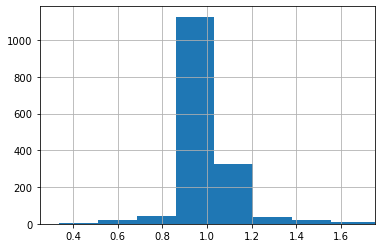

In [80]:
differ['otn']=differ['SUMMSQOIL']/differ['SUMMQOIL']
differ.loc[~differ['otn'].isin([0, 'inf']), 'otn'].hist(bins=100)
plt.xlim(0.25,1.75)

In [81]:
differ.loc[~differ['otn'].isin([0, 'inf']), 'otn'].describe()

count    1621.000000
mean        1.061731
std         0.538006
min         0.337158
25%         0.991831
50%         1.006774
75%         1.035419
max        17.733237
Name: otn, dtype: float64

In [82]:
px.scatter(differ, x='SUMMQOIL', y='SUMMSQOIL')

In [83]:
differ['otn'].sort_values(ascending=False).head(10)

WELL
488A     17.733237
10814     9.138316
10821     6.980620
33P       3.926569
20545     3.791457
20443     3.567361
20541     3.332521
20610     3.054595
9568      3.023387
1N        2.894570
Name: otn, dtype: float64

### Анализ отклонений по давлениям

(0.0, 2.0)

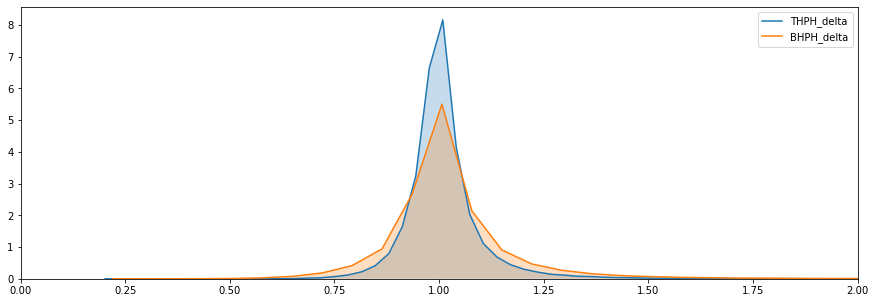

In [84]:
fig, ax= plt.subplots(figsize=(15,5))

sns.kdeplot(data=df.loc[df['status']=='prod', 'THPH_delta'], shade=True)
sns.kdeplot(data=df.loc[df['status']=='prod', 'BHPH_delta'], shade=True)

plt.xlim(0,2)

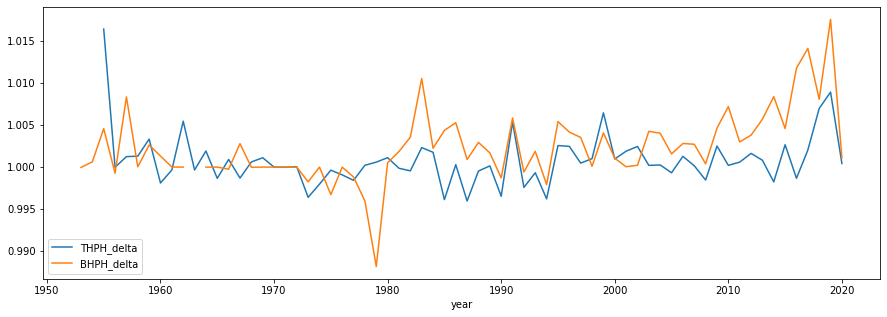

In [85]:
df.loc[df['status']=='prod'].groupby('year')['THPH_delta'].median().plot(figsize=(15,5))
df.loc[df['status']=='prod'].groupby('year')['BHPH_delta'].median().plot(figsize=(15,5))
plt.legend()

# Обработка продуктивностей

In [86]:
product_calc(df, smooth= True)
mproduct_calc(df)

,WELL,date,QOIL,QWAT,QWIN,WEFA,BHPH,THPH,QLIQ,WCT,...,SUMMQLIQ,MONQWIN,SUMMQWIN,MONSQOIL,SUMMSQOIL,MONSQLIQ,SUMMSQLIQ,SPROD,PROD,PRODM
date,,,,,,,,,,,,,,,,,,,,,
1950-04-01,1,1950-04-01,24.84039,0.0,0.0,0.16667,NaN,NaN,24.84039,0.0,...,0.124204,0.0,0.000000,238.636753,0.238637,238.636753,0.238637,NaN,NaN,NaN
1950-05-01,1,1950-05-01,56.46565,0.0,0.0,1.00000,NaN,NaN,56.46565,0.0,...,1.874640,0.0,0.000000,1554.062791,1.792700,1554.062791,1.792700,NaN,NaN,NaN
1950-06-01,1,1950-06-01,61.44055,0.0,0.0,0.96667,NaN,NaN,61.44055,0.0,...,3.656422,0.0,0.000000,1535.635662,3.328335,1535.635662,3.328335,NaN,NaN,NaN
1950-07-01,1,1950-07-01,67.61000,0.0,0.0,0.92876,NaN,NaN,67.61000,0.0,...,5.603019,0.0,0.000000,1605.361581,4.933697,1605.361581,4.933697,NaN,NaN,NaN
1950-08-01,1,1950-08-01,64.30409,0.0,0.0,0.92876,NaN,NaN,64.30409,0.0,...,7.454434,0.0,0.000000,1658.079886,6.591777,1658.079886,6.591777,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-01,9N,2019-12-01,0.00000,0.0,0.0,0.00000,NaN,NaN,0.00000,NaN,...,38.368230,0.0,2747.860965,0.000000,2.084850,0.000000,38.011950,NaN,NaN,NaN
2020-01-01,9N,2020-01-01,0.00000,0.0,0.0,0.00000,NaN,NaN,0.00000,NaN,...,38.368230,0.0,2747.860965,0.000000,2.084850,0.000000,38.011950,NaN,NaN,NaN
2020-02-01,9N,2020-02-01,0.00000,0.0,0.0,0.00000,NaN,NaN,0.00000,NaN,...,38.368230,0.0,2747.860965,0.000000,2.084850,0.000000,38.011950,NaN,NaN,NaN


In [87]:
df.loc[((df['SPROD']>df['PROD'].max())&(df['status']=='prod')), 'SPROD'] = np.NaN
df.loc[((df['PRODM']>df['PROD'].max())&(df['status']=='prod')), 'PRODM'] = np.NaN
df.loc[((df['SPROD']<0)&(df['status']=='prod')), 'SPROD'] = np.NaN
df.loc[((df['PRODM']<0)&(df['status']=='prod')), 'PRODM'] = np.NaN

In [88]:
df.loc[df['status']=='prod', ['THPH_delta', 'BHPH_delta', 'QLIQ_delta', 'WCT_delta']].describe()

,THPH_delta,BHPH_delta,QLIQ_delta,WCT_delta
count,60407.000000,107210.000000,413011.000000,3.658750e+05
mean,1.010904,1.024048,2.418890,inf
std,0.099238,0.172623,33.453164,NaN
min,0.235108,0.270662,0.125000,1.250000e-01
25%,0.968624,0.954929,0.914117,9.566927e-01
50%,1.000453,1.004103,0.999851,9.988591e-01
75%,1.036569,1.062667,1.114214,1.050856e+00
max,3.364134,7.253264,11022.665612,inf


# Вводим номер интересующей скважины

In [92]:
well_df = df.loc[df['WELL']=='152']

In [113]:
b, a = signal.butter(1, 0.05)
well_df['SBHPH']= signal.filtfilt(b, a, well_df['BHPH'].interpolate(method='time').fillna(0))
#well_df['STHPH']= well_df['THPH'].interpolate(method='time')

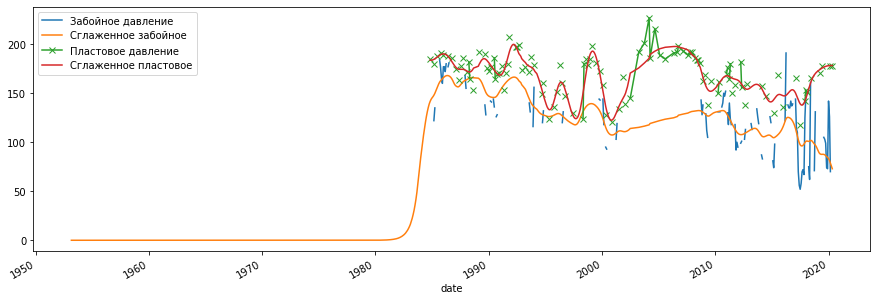

In [114]:
#well_df['BHPH'].interpolate(method='time').plot(figsize=(15,5),linestyle ='--', color='red', alpha =0.5)
well_df['BHPH'].plot(figsize=(15,5))
well_df['SBHPH'].plot()

#well_df['THPH'].interpolate(method='time').plot(figsize=(15,5),linestyle ='--', color='red', alpha =0.5)
well_df['THPH'].plot(marker ="x")
well_df['STHPH'].plot()
plt.legend(['Забойное давление', 'Сглаженное забойное', 'Пластовое давление', 'Сглаженное пластовое'])
#plt.ylim(0, 250)
plt.savefig('Press.png')

In [90]:
fig= go.Figure()
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.BHPH, mode='markers',
                         marker=dict(size=3, color="MediumPurple"), name='Забойное давление'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.SBHPH, name='Сглаженное забойное'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.THPH, mode='markers', 
                         marker=dict(size=3, color="tomato", symbol='square-x'), name='Пластовое давление'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.STHPH, name='Сглаженное пластовое'))

fig.update_layout(template= 'plotly_white', title='Сопоставление давления', xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Дата')), 
                 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Давление, атм')))

#offline.plot(fig,  filename='Давление.png')


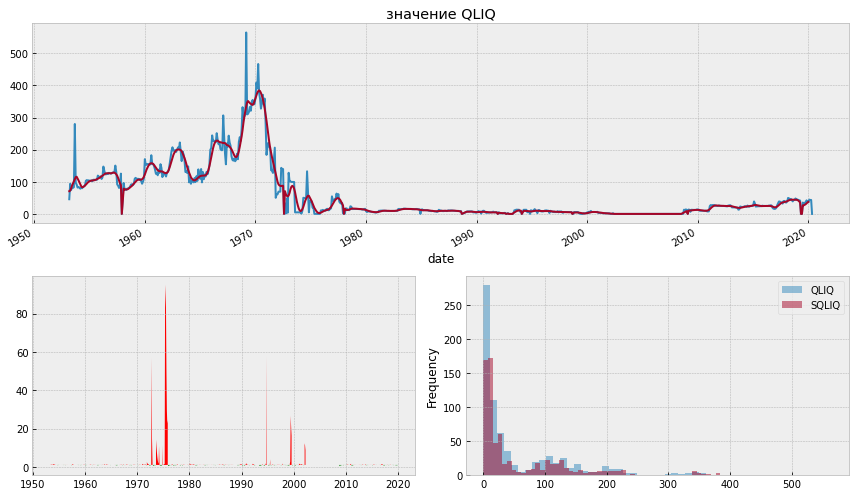

In [51]:
tsplot(well_df, 'QLIQ')

In [65]:
fig= go.Figure()
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.SPROD, name='Сглаженная продуктивность'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.PRODM, name='Продуктивность модель'))
fig.update_layout(template= 'plotly_white', title='Продуктивность', xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Дата')), 
                 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Продуктивность, т/сут/атм')))


In [66]:
fig= go.Figure()
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.WCT, name='Обводненность'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.SWCT, name='Сглаженная обводненность'))
fig.update_layout(template= 'plotly_white', title='Сопоставление обводненности', xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Дата')), 
                 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Обводненность, %')))

#offline.plot(fig,  filename='Обводненность')

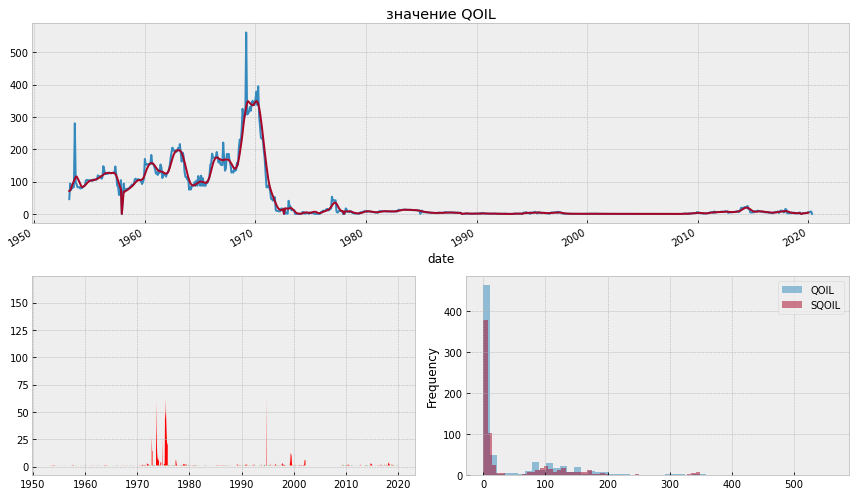

In [67]:
tsplot(well_df, 'QOIL')

fig= go.Figure()
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.PROD, mode='markers',
                         marker=dict(size=3, color="MediumPurple"), name='Продуктивность'))
fig.add_trace(go.Scatter(x=well_df.date, y=well_df.SPROD, name='Сглаженная продуктивность'))
fig.update_layout(template= 'plotly_white', title='Сопоставление продуктивностей', xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Дата')), 
                 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Продуктивность, т/сут/атм')))
offline.plot(fig)

to_export = df[['WELL', 'date', 'SQOIL', 'SQLIQ', 'SWIN','SBHPH', 'STHPH', 'WEFA']]
to_export.fillna(0).to_csv('smooth.csv')

# Формируем датафрейм

In [1837]:
t=T-pd.DateOffset(months=12)

In [1838]:
fr = df.loc[df['date'].between(t,T),['WELL', 'MONQOIL', 'MONQWIN','MONQLIQ']].groupby('WELL').apply(lambda x: x.sum()/330)

In [1839]:
fr

,MONQOIL,MONQWIN,MONQLIQ
WELL,,,
1,0.000000,0.000000,0.000000
10051,0.000000,0.000000,0.000000
10751,0.000000,0.000000,0.000000
10751D,1.422033,93.282866,3.537586
10752,0.000000,0.000000,0.000000
...,...,...,...
9647,0.000000,0.000000,0.000000
9648,0.000000,64.502980,0.000000
9649,0.427609,0.000000,0.561561


In [1840]:
delta = df.loc[df['date'].isin([t,T]),['WELL', 'QOIL', 'QLIQ', 'QWIN','STHPH', 'SBHPH', 'WCT']].groupby('WELL').apply(lambda x: x.diff().dropna(how='all'))
delta.reset_index(inplace=True)
delta.index=delta['WELL']
delta.drop(columns=['WELL', 'date'], inplace=True)

In [1841]:
delta

,QOIL,QLIQ,QWIN,STHPH,SBHPH,WCT
WELL,,,,,,
1,0.00000,0.00000,0.00000,3.694822e-13,NaN,NaN
10051,0.00000,0.00000,0.00000,1.092673e+01,NaN,NaN
10751,0.00000,0.00000,0.00000,5.954348e-11,NaN,NaN
10751D,0.00000,0.00000,-38.57998,2.576892e+01,-203.230748,NaN
10752,0.00000,0.00000,0.00000,-1.556794e-05,NaN,NaN
...,...,...,...,...,...,...
9648,0.00000,0.00000,-219.54779,1.704075e-01,NaN,NaN
9649,0.61774,0.72261,0.00000,-1.047930e+01,NaN,NaN
9649,-0.61774,-0.72261,0.00000,-5.175752e-01,NaN,NaN


In [1844]:
df.loc[(df['WELL']=='10051')&df['date'].isin([t,T])]

,WELL,date,QOIL,QWAT,QWIN,WEFA,BHPH,THPH,QLIQ,WCT,...,SUMMQLIQ,MONQWIN,SUMMQWIN,MONSQOIL,SUMMSQOIL,MONSQLIQ,SUMMSQLIQ,SPROD,PROD,PRODM
date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,10051,2019-04-01,0.0,0.0,0.0,1.0,NaN,NaN,0.0,NaN,...,86.509331,0.0,0.0,0.0,28.858271,0.0,85.814974,NaN,NaN,NaN
2020-04-01,10051,2020-04-01,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,...,86.509331,0.0,0.0,0.0,28.858271,0.0,85.814974,NaN,NaN,NaN


In [1843]:
fr=pd.merge(left=fr, right=delta, left_index=True, right_index=True)

df.loc[(df['date'].isin([t,T])&(df['WELL']=='10051')),['QOIL', 'QLIQ', 'QWIN','STHPH', 'SBHPH', 'WCT']].diff().dropna(how='all')

In [1845]:
fr=pd.merge(left=fr, right=df.loc[df['date']>'01.01.2000',['WELL', 'SPROD']].groupby('WELL').agg('median'),
            left_index=True, right_index=True)

In [1846]:
fr=pd.merge(left=fr, right=df.loc[:,['WELL', 'SUMMQOIL', 'SUMMQLIQ']].groupby('WELL').agg('max'),
            left_index=True, right_index=True)

In [1847]:
fr.columns = ['QOIL', 'QWIN', 'QLIQ', 'DQOIL', 'DQLIQ', 'DQWIN', 'DSTHPH', 'DSBHPH', 'DWCT',
       'SPROD', 'SUMMQOIL', 'SUMMQLIQ']

In [1848]:
fr=pd.merge(left=fr, right=df.loc[df['date']==T,['WELL', 'status', 'STHPH', 'SBHPH']].groupby('WELL').agg('max'),
            left_index=True, right_index=True)

# ЗАпасы

In [1849]:
well_oil = pd.read_table(r'D:\project\Minnib_project\SCHED_PATTERNS\reports\plan_drilling\rezultat300.txt', usecols=[0, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15], decimal=b',')

In [1850]:
index_col=['well', 'D0', 'D1a', 'D1b1', 'D1b2', 'D1b', 'D1v', 'D1g1', 'D1g2', 'D1g3', 'D1d']
well_oil.columns = index_col
well_oil['well'] = well_oil['well'].astype('str')
well_oil.index = well_oil['well']
well_oil.drop(columns='well', inplace=True)
well_oil.drop(index='nan', inplace=True)

In [1851]:
well_oil = pd.merge(left=well_oil, right=well_oil.div(well_oil.sum(axis=1), axis=0), left_index= True, right_index=True)

In [1852]:
well_oil

,D0_x,D1a_x,D1b1_x,D1b2_x,D1b_x,D1v_x,D1g1_x,D1g2_x,D1g3_x,D1d_x,D0_y,D1a_y,D1b1_y,D1b2_y,D1b_y,D1v_y,D1g1_y,D1g2_y,D1g3_y,D1d_y
well,,,,,,,,,,,,,,,,,,,,
9N,2626.8,0.0,26.8,1199.2,338.2,5094.6,4334.6,22659.0,510.4,0.0,0.071401,0.000000,0.000728,0.032596,0.009193,0.138479,0.117821,0.615908,0.013873,0.000000
20383,8962.3,4048.5,0.0,0.0,3368.7,5108.3,1906.1,8013.7,876.7,3.9,0.277572,0.125386,0.000000,0.000000,0.104332,0.158210,0.059034,0.248193,0.027152,0.000121
122,4530.5,5227.5,3648.9,5815.9,255.3,4785.3,369.1,2289.2,1606.7,0.0,0.158807,0.183238,0.127904,0.203864,0.008949,0.167738,0.012938,0.080243,0.056319,0.000000
157,703.6,1805.2,561.4,0.0,2235.4,10669.0,3207.0,2907.5,3031.7,0.0,0.028009,0.071861,0.022348,0.000000,0.088986,0.424708,0.127663,0.115741,0.120685,0.000000
32451,266.7,11800.2,5765.9,1798.2,11756.9,12681.7,29473.9,7746.6,2687.8,0.0,0.003176,0.140516,0.068660,0.021413,0.140000,0.151012,0.350972,0.092246,0.032006,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P-995,12725.4,8909.8,60.2,4643.5,1311.1,3055.9,7929.6,3652.0,64.8,1054.8,0.293164,0.205261,0.001387,0.106976,0.030205,0.070401,0.182680,0.084134,0.001493,0.024300
P-996,5890.8,1481.9,0.0,2358.5,1575.4,1704.1,2984.7,1844.1,0.0,0.0,0.330211,0.083068,0.000000,0.132207,0.088310,0.095524,0.167309,0.103372,0.000000,0.000000
P-997,859.9,1683.4,347.6,155.0,2362.7,3151.4,4463.2,685.6,0.0,0.0,0.062726,0.122797,0.025356,0.011307,0.172349,0.229882,0.325572,0.050012,0.000000,0.000000


In [1853]:
well_oil['Total'] = well_oil.loc[:, ['D0_x', 'D1a_x', 'D1b1_x', 'D1b2_x', 'D1b_x', 'D1v_x', 'D1g1_x', 'D1g2_x', 'D1g3_x', 'D1d_x']].sum(axis=1)

In [1854]:
fr=pd.merge(left=fr, right=well_oil, left_index=True, right_index=True, how='left')

In [1855]:
fr.to_excel('wells_dataframe.xlsx')

In [1856]:
fr.loc[((fr['QOIL']==0)&(fr['QWIN']==0)&(fr['QLIQ']==0))].to_excel('stop_wells.xlsx')

# Блок работы со сводным анализом исторической и модельной информации
#### Анализ давления
#### Анализ продуктивнсоти

In [44]:
import matplotlib.dates as mdate
locator = mdate.YearLocator()

In [45]:
os.chdir(r'D:\project\Minnib_project\SCHED_PATTERNS\reports')

In [46]:
model=pd.read_csv('productiviti.csv', index_col='date')

In [50]:
model.index =pd.to_datetime(model.index)

In [51]:
model.loc[model['SPROD']<-1, 'SPROD']=np.nan

In [52]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

In [63]:
def press_graph(y):
    '''Create pic for field/
        y = dataframe from field'''
    
    fig = plt.figure(figsize=(25, 10)) 
    ax1 = plt.subplot()
    ax1.plot(y['STHPH', 'median'], color='k')
    ax1.plot(y['MPRES', 'median'], color='r')
    ax1.fill_between(y.index, y['STHPH', 'q2'], y['STHPH', 'median'],\
                                where=y['STHPH', 'q2']>y['STHPH', 'median'], \
                                facecolor='green', alpha=0.3)
    ax1.fill_between(y.index, y['STHPH', 'q1'], y['STHPH', 'median'],\
                                where=y['STHPH', 'median']>y['STHPH', 'q1'], \
                                facecolor='green', alpha=0.3)
    ax1.fill_between(y.index, y['MPRES', 'q2'], y['MPRES', 'median'],\
                                where=y['MPRES', 'q2']>y['MPRES', 'median'], \
                                facecolor='red', alpha=0.3)
    ax1.fill_between(y.index, y['MPRES', 'q1'], y['MPRES', 'median'],\
                                where=y['MPRES', 'median']>y['MPRES', 'q1'], \
                                facecolor='red', alpha=0.3)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Press', fontsize=14)
    ax1.grid(False)
    fig.autofmt_xdate()
def prod_graph(y):
    '''Create pic for field/
        y = dataframe from field'''
    
    fig = plt.figure(figsize=(25, 10)) 
    ax1 = plt.subplot()
    ax1.plot(y['SPROD', 'median'], color='k')
    ax1.plot(y['MPROD', 'median'], color='r')
    ax1.fill_between(y.index, y['SPROD', 'q2'], y['SPROD', 'median'],\
                                where=y['SPROD', 'q2']>y['SPROD', 'median'], \
                                facecolor='green', alpha=0.3)
    ax1.fill_between(y.index, y['SPROD', 'q1'], y['SPROD', 'median'],\
                                where=y['SPROD', 'median']>y['SPROD', 'q1'], \
                                facecolor='green', alpha=0.3)
    ax1.fill_between(y.index, y['MPROD', 'q2'], y['MPROD', 'median'],\
                                where=y['MPROD', 'q2']>y['MPROD', 'median'], \
                                facecolor='red', alpha=0.3)
    ax1.fill_between(y.index, y['MPROD', 'q1'], y['MPROD', 'median'],\
                                where=y['MPROD', 'median']>y['MPROD', 'q1'], \
                                facecolor='red', alpha=0.3)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Press', fontsize=14)
    ax1.set_ylim((0,5))
    ax1.grid(False)
    fig.autofmt_xdate()

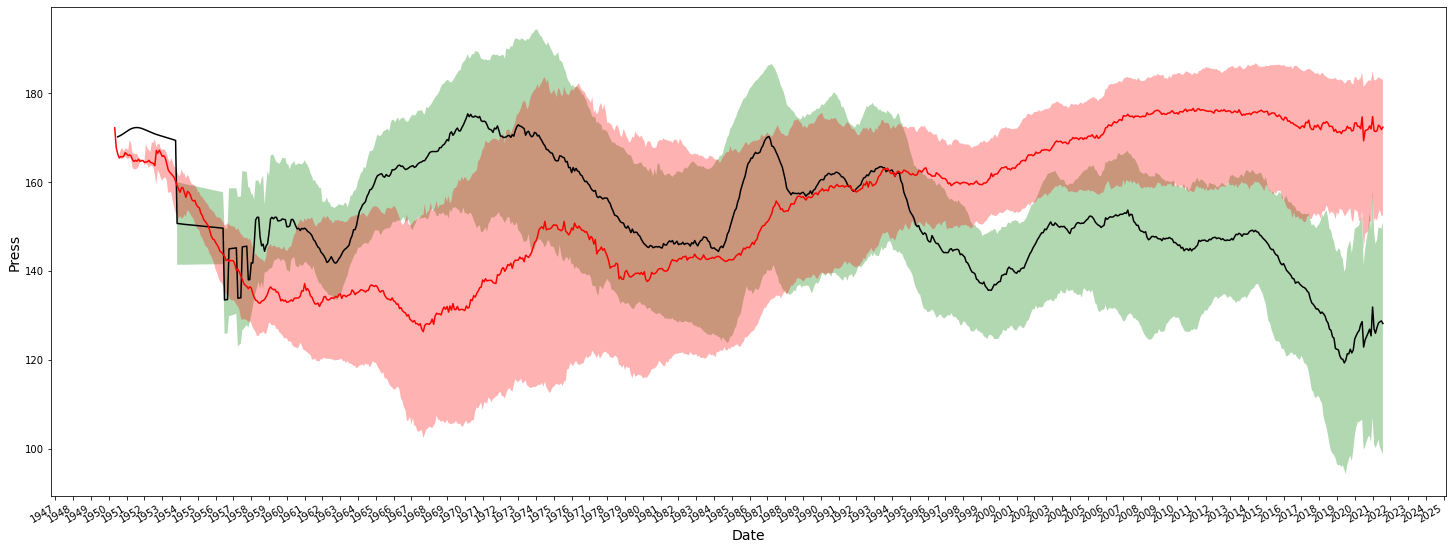

In [64]:
press_graph(model.loc[model['status']=='prod',['STHPH', 'MPRES']].groupby(model.loc[model['status']=='prod'].index)\
.agg([np.median,q1, q2]))

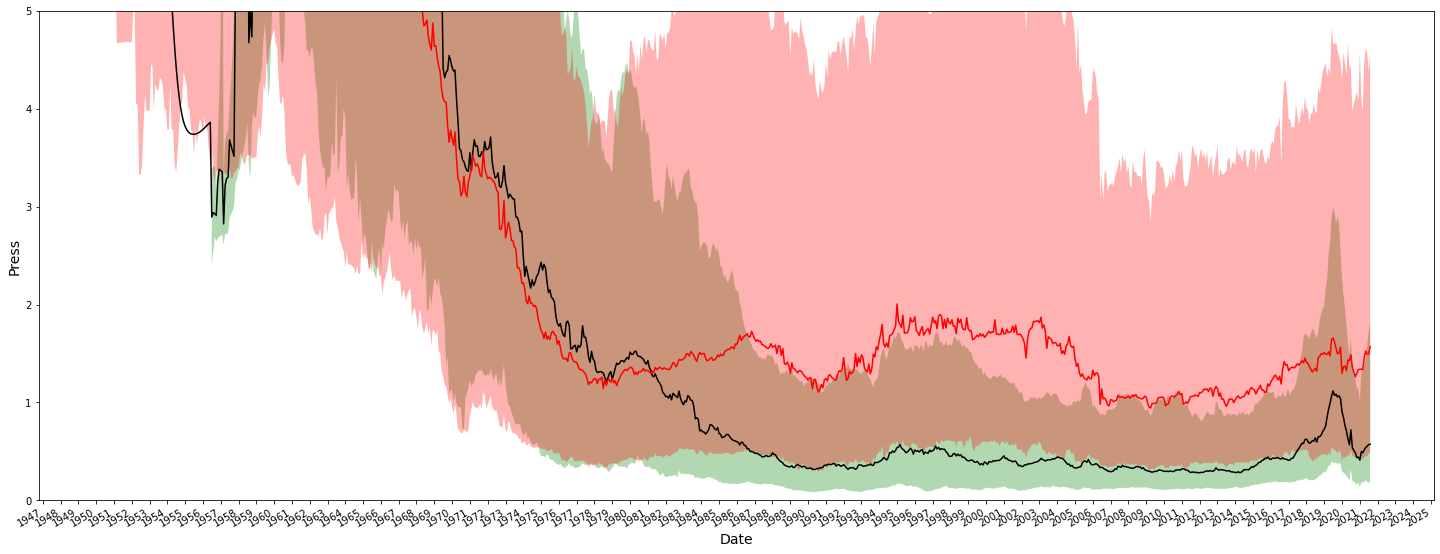

In [65]:
prod_graph(model.loc[model['status']=='prod',['SPROD', 'MPROD']].groupby(model.loc[model['status']=='prod'].index)\
.agg([np.median,q1, q2]))

In [26]:
model['Pres_dif']=(model['THPH']-model['MPRES'])**2

In [27]:
model.loc[model['status']=='prod',['Pres_dif']].groupby(model.loc[model['status']=='prod', 'well'])\
.agg('sum').sort_values(by='Pres_dif', ascending=False)

,Pres_dif
well,
20693,591346.249771
20465,501020.152507
20221,467942.000420
9597,465618.937526
10760,431679.958095
...,...
429A,0.000000
427,0.000000
426,0.000000


In [29]:
model =pd.DataFrame(model.groupby(by='well').apply(summ_by_well))

KeyboardInterrupt: 

In [28]:
def summ_by_well(frame):
    frame['PRESS_DIF'] = (frame['THPH']-frame['MPRES'])**2
    frame['PRESS_DIF'] = frame['PRESS_DIF'].cumsum()
    return frame